## Step 1. Obtain Snapshots in `U`

In [1]:
import numpy as np
import burgers

def smooth_ic(x, t_0=-1.5, alpha=5.0, s=1.0):
    return np.exp(- alpha * (x - s * t_0) * (x - s * t_0))

def upwind_advection(nt, nx, ic, s=1.0, x_range=[-2., 2.], t_range=[-2., 2.]):
    """
    upwind scheme for linear advection.
    smears out sharp shock.
    only works for s > 0.
    """
    a, b = x_range
    t_min, t_max = t_range
    x = np.linspace(a, b, nx+1)
    dx, dt = (b - a)/nx, (t_max - t_min)/nt
    
    # define the initial condition
    u, u_new = ic(x), np.zeros(nx + 1)
    U = np.zeros((nt + 1, nx + 1))
    U[0, :] = u
    
    # advance in time:
    for t in range(nt):
        u_upstream = np.concatenate([[0.0], u[:-1]])
        
        u_new = u - dt/dx * s * (u - u_upstream)
        u = u_new
        U[t + 1, :] = u
    return x, U

x, Phi = upwind_advection(100, 100, smooth_ic)

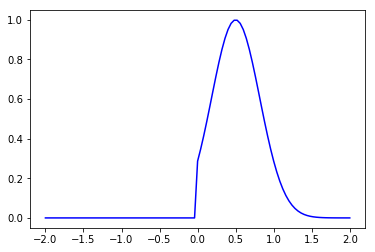

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, Phi[50, :], 'b-')
plt.show()

## Step 2: Obtained Reduced Order Bases from snaphots `U`
* first obtain that for SVD
* then use autoencoder to obtained one

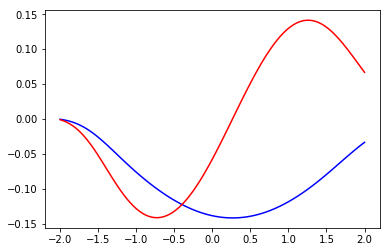

In [3]:
U, s, V = np.linalg.svd(Phi.T, full_matrices=False, compute_uv=True)
fig, ax = plt.subplots()
ax.plot(x, U[:, 0], 'b-', x, U[:, 1], 'r-')
plt.show()

training stage finished


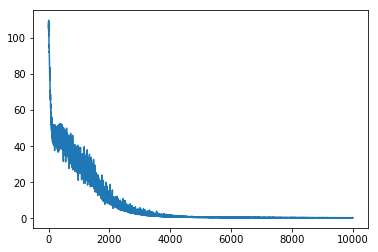

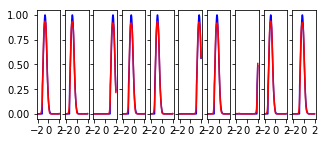

In [7]:
# see https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py
# for reference. simplify some places with tensorflow utility functions.
import tensorflow as tf

"""
parameters for the network
"""
n_input = nx = Phi.shape[1]
n_hidden_1 = int(nx/4)
n_hidden_2 = 5
# TODO: use everything here to train
X_train = Phi.copy()
N = X_train.shape[0]
X_val = Phi[N:, :]
batch_size = 10
training_epoch = 1000
lr = 0.001

"""
define the computational graph
"""
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder("float", [None, n_input])

def encoder(x):
    y = tf.layers.dense(x, n_hidden_1, activation=tf.nn.sigmoid)
    z = tf.layers.dense(y, n_hidden_2, activation=tf.nn.sigmoid)
    return z

def decoder(x):
    y = tf.layers.dense(x, n_hidden_1, activation=tf.nn.sigmoid)
    z = tf.layers.dense(y, n_input, activation=tf.nn.sigmoid)
    return z

encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op
y_true = X

cost = tf.nn.l2_loss(y_pred - y_true)
optimizer = tf.train.RMSPropOptimizer(lr).minimize(cost)

init = tf.global_variables_initializer()

loss_history = list()
sess.run(init)

for epoch in range(training_epoch):
    total_batch = int(N/batch_size)
    np.random.shuffle(X_train)
    for i in range(total_batch):
        begin, end = i * batch_size, min(N, (i + 1) * batch_size)
        X_b = X_train[begin:end, :]
        _, c = sess.run([optimizer, cost], feed_dict={X:X_b})
        loss_history.append(c)

print("training stage finished")
fig, ax = plt.subplots()
ax.plot(loss_history)

recon_Phi = sess.run(y_pred, feed_dict={X:Phi})


fig, ax = plt.subplots(1, 10, figsize=(5, 2), sharey=True)
for i in range(10):
    idx = np.random.randint(N)
    ax[i].plot(x, Phi[idx, :], 'b-', x, recon_Phi[idx, :], 'r-')
plt.show()

In [8]:
# get the weights for decoder
weights = dict()
for v in tf.trainable_variables():
    value = v.eval(session=sess)
    weights[v.name] = value

for k in weights.keys():
    print(k)
    print(weights[k].shape)

dense/kernel:0
(101, 25)
dense/bias:0
(25,)
dense_1/kernel:0
(25, 5)
dense_1/bias:0
(5,)
dense_2/kernel:0
(5, 25)
dense_2/bias:0
(25,)
dense_3/kernel:0
(25, 101)
dense_3/bias:0
(101,)


In [9]:
from statsmodels.tsa.api import VAR, DynamicVAR

training_data = Phi[:60, :]
ys = sess.run(encoder_op, feed_dict={X:training_data})
#print(ys)
model = VAR(ys)
results = model.fit(2)
y_forecast = results.forecast(ys[-2:], 39)
y_actual = sess.run(encoder_op, feed_dict={X:Phi})

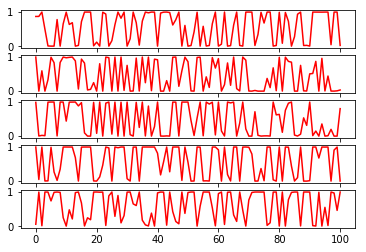

In [34]:
fig, ax = plt.subplots(5, 1)
for i in range(5):
    ax[i].plot(y_actual[:, i], 'r-')

## Step 2: get the parameters for ARIMA models
* run encode_op to get reduced order model

## Step 3: Use ARIMA to model low-dimensional PDE and compare the losses

In [32]:
# redfine the graph to run decoder
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder("float", [None, 5])

W0 = tf.Variable(initial_value=weights['dense_2/kernel:0'])
b0 = tf.Variable(initial_value=weights['dense_2/bias:0'])
W1 = tf.Variable(initial_value=weights['dense_3/kernel:0'])
b1 = tf.Variable(initial_value=weights['dense_3/bias:0'])

def explicit_decoder(x, W0, b0, W1, b1):
    y = tf.nn.sigmoid(x @ W0 + b0)
    z = tf.nn.sigmoid(y @ W1 + b1)
    return z

Y = explicit_decoder(X, W0, b0, W1, b1)

init = tf.global_variables_initializer()
sess.run(init)
Y_forecast = sess.run(Y, feed_dict={X:y_forecast})
Y_recon = sess.run(Y, feed_dict={X:y_actual})

np.linalg.norm(Y_forecast - Phi[62:, :], ord='fro')/(np.sqrt(40 * 101))

0.35493145738818049

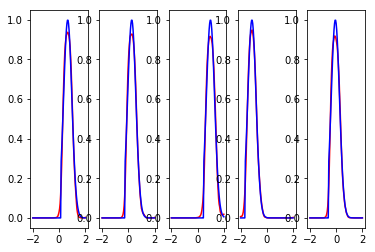

In [33]:
# visualize some random forecast
fig, axes = plt.subplots(1, 5)
for i in range(5):
    idx = np.random.randint(40)
    axes[i].plot(x, Y_recon[idx, :], 'r-', x, Phi[idx, :], 'b-')

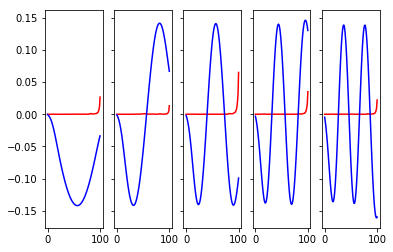

In [30]:
# visualize the basic modes
mode_forecast = np.eye(5)
mode = sess.run(Y, feed_dict={X:mode_forecast})
fig, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ax[i].plot(Y_forecast[i, :], 'r-', U[:, i], 'b-')

In [ ]:
# compare with svd reconstrunction loss:
np.linalg.norm(U[:, :5] @ y_forecast.T - Phi[61:, :].T, ord='fro')/(np.sqrt(40 * 101))